In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
import datetime
import pyLDAvis
import pyLDAvis.sklearn
import warnings
import spacy
from   sklearn.model_selection import cross_val_score, train_test_split
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.model_selection import GridSearchCV

# Final Project
#### Table of Contents
0. Project Team
1. Introduction and Hypothesis
        I. Introduction
        II. Research Question
        III. Hypothesis
        IV. Expectations
2. Data and Methods
        I. Overview of Methods and Tasks
        II. Corpus Creation
        III. Metadata + Dataset Information
        IV. Exploratory Data Analysis
3. Results
4. Conclusion and Discussion
5. Resources Consulted
6. Bibliography

## 0. Project Team

Estelle Hooper (ehh52) and Gabriella Chu (gc386)

## 1. Introduction and Hypothesis

### I. Introduction
During the week of January 1, 2000, the number one song on the [Billboard Hot 100 chart](https://www.billboard.com/charts/hot-100/2000-01-01/) was "Smooth" by Santana Featuring Rob Thomas. According to Genius lyrics(https://genius.com/2953666), "'Smooth' is a pinnacle of the tail end of the rock era, and a perfect example of a smooth transition from the classic rock sound (Santana) to modern adult contemporary music (Thomas).' In the lyrics, Santana and Thomas sing to a love interest (presumably a woman).
>My muñequita, my Spanish Harlem Mona Lisa<br>
You're my reason for reason, the step in my groove

>I would give my world to lift you up<br>
I could change my life to better suit your mood<br>
Because you're so smooth

When comparing "Smooth" to [today's (May 19, 2022)](https://www.billboard.com/charts/hot-100/) number one song on the Billboard Hot 100, ["First Class" by Jack Harlow](https://genius.com/Jack-harlow-first-class-lyrics), the lyrics are on the same theme of romance, yet treated in a different way.

>I been a (G), throw up the (L), s*x in the (A.M.), uh-huh
(O-R-O-U-S, yeah) <br>
And I can put you in (First class, up in the sky), mm, mm
I can put you in (First class)

With a little over a 6 decade difference, it is common knowledge that the most popular genre/sound of music will evolve over time with different instruments and technology. In this case, it's Santana's classic rock to Jack Harlow's hip-hop. However, lyrical themes tend to remain, such as love or youth. Given how many and how often songs rise in popularity, as evidenced by the existence of Billboard's Hot 100 chart (since 1958!) that updates weekly, we find that computational methods would be ideal to analyze the large sum of these popular songs that rise in the music market and analyze the changes and nuances in these topics over time. For example, both "Smooth" and "First Class" are number one hits of their time addressing a love interest, yet the former uses more chivalrous lyrics and the latter more sexual and playful.


### II. Research Question
#### What lyrical inspirations define the music industry every decade, and how has their treatment changed over time?
By analyzing the most popular songs of 1960-2021 according to the Billboard Hot 100 charts and their lyrics, we hope to discover distinct topics in all these songs. We want to know the life cycle of these topics, such as if they endured across decades, fell or rose in popularity, or were only popular for a certain decade. <br>

In short, to answer our research question, we will use topic modeling on the most popular songs from 1960 to 2021 and visualize them using time-series plots and scatterplots. Then, we will verify these topics' distinctiveness to each decade or year in two avenues. First, we'll read samples of the songs assigned to these topics and their metadata (date on chart, weeks on chart, etc.). Second, we will predict year or decade using the matrix containing these topic-modelling distributions.


### III. Hypothesis 
As hinted in the introduction, we expect to see a topic like love be an enduring theme across all decades, but we believe that the LDA topic modelling will distinguish lyrics about physical attraction and flowery, romantic lyrics (therefore, creating multiple topics about romance). We also expect to see some topics whose top words include niche words specific to a genre that was popular during the time. For example, R&B and rap (particularly, African-American artists) rose in the 1990-2000, meaning that topics with AAVE (African American Vernacular English) could arise as a proxy for those genres.

### IV. Expectations
The foundation of our research project is dependent on topic modelling, and if we will be able to find meaningful and distinguishable topics in the song data. Overall, we don't expect to have many different topics given the size of our corpus and span of time it covers. We only expect very common themes to arise as a topic (such as love or youth), but other lyrical topics in music to be lost. For example, many artists are lyrically inspired by politics, but it will be difficult for the topic modelling to pick up a broad topic of "current events" because the names of politicians and news events are all very specifc, and the model does not have the domain knowledge to lump them all together.

## 2. Data and methods

### I. Overview of Methods and Tasks

Before carrying our LDA topic modeling on the corpus we created, we will conduct some exploratory data analysis by doing basic SVD to graph the songs in 2-D space in order to look at any immediate outliers and if any visible clusters can be observed. Seeing any clusters could give some intuition for the number of topics to select as a parameter for topic modeling. We will also graph some time-series plots  based on the summary statistics taken from the song metadata to observe general trends about song popularity over time.<br>

LDA would be appropriate because it allows us to find the degree to which the topical distribution in each document is expected to be sparse. Topical sparsity is advantageous in terms of interpretability which is super important for being about to understand our results. In addition, using LDA to break down the songs by topic would allow us to avoid some of the issues that straight word counts could lead us to due to the amount of lyrics that we are working with, such as overfitting in our models due to the feature space having too many dimensions. <br>

Using these results, we could try to predict when a certain song was released based on the topic of the song to see if there has been a change in the popularity of certain topics over time. We will also pull songs from each topic and their the most popular words to tune the topics. We will also plot more time-series plots to evaluate the popularity of these topics over time.<br>

To further test how distinguishable these topics are in accordance with the time period, we will use the doc-topic matrix to cross validate and predict the year of these songs. We will conduct the same prediction task with a word-embedding matrix and a word counts (bag of words matrix). If the doc-topic matrix performs better than the other two matrices, then we can conclude that topics are better predictors for years rather than the words themselves. Furthermore, we would be able to lean towards the conclusion that there are lyrical topics that define certain time periods.

### II. Corpus Creation

To answer our research question, we created our own corpus consisting of the Billboard Hot 100 songs for every week in the years 1960-2021, covering a little more than 6 decades of music **(roughly, 62 years * 52 weeks * 100 songs = 322,400 music entries)**. Each week, Billboard.com ranks the "Hot 100" songs, stating its peak position on the chart (of all time) and the number of weeks it has been on the chart. We chose to use the Hot 100 charts instead of yearly charts because the Hot 100 charts provide fluctuations in popularity, such as giving statistics for the number of weeks a song has been on a chart. Because Billboard provides archives of this information, we webscraped this data using Beautiful Soup to obtain the most popular songs of the week and then used the song title and artist information to generate links in order to webscrape lyrics from Genius.com. We chose Genius.com because it's the world's greatest collection of song lyrics and uses a mostly-consistent formula for generating its song URLS.<br>

To collect this data, we wrote the following functions:
- `song_data()` given a start and end date, creates a pandas dataframe containing all weekly Billboard Hot 100 Chart song metadata and all the associated song lyrics (text data) from Genius.com
- `metadata()` (helper function) webscrapes Billboard Hot 100 Chart data.
- `append_lyrics()` (helper function) webscrapes Genius lyrics using information from song metadata.

Doing this was extremely computationally expensive. Generating the song data (metadata + lyrics) for one year only takes roughly 8 minutes, but seeing as we wanted to cover every weekly chart for 62 years, this means the time needed to collect this data is in total **8.2 hours**! To do this within a reasonable amount of time, we split the work among several notebooks, ran them simultaneously, and concatenated them all outside of this notebook. We demo these functions with only two weeks below.

####  **A. Limitations**
Our functions were not able to pick up on a a decent number of edge cases. Typically, the formula for a Genius.com lyrics URL is `'https://genius.com/'`+`artist name`+`song title`+`'-lyrics'` but songs with ensemble casts, such as in TV shows or musicals, were able to be added to the corpus. Additionally, compared to the 1960s-1980s, many 21st century musicians use interesting punctuation for their stage names, and Genius.com treated the punctuation for these artists inconsistently for their URLS. For example, our function was able to get lyrics for A`$`AP Rocky, but not Ty Dolla `$`ign. Additionally, while 62 years is a long span of time, it captures a very small part of the history of music. Billboard.com only has chart information dating back to 1958. To answer our research question, a longer span of time would be preferred.

In [2]:
def song_data(start,end):
    '''
    Creates a dataframe with all Billboard Hot 100 metadata and song lyrics (from Genius.com) for a specified range of dates.
    start: start date, a string "YYYY-MM-DD"
    end: end date, a string "YYYY-MM-DD"
    returns: a pandas dataframe.
    see metadata() and append_lyrics() for further documentation.
    '''
    dates=pd.date_range(start,end,freq='W-SAT')
    Dates=[date.strftime('%Y-%m-%d') for date in dates]
    #Dates=valid_dates(Dates)
    metadata_dfs=[]
    for date in Dates:
        metadata_dfs.append(metadata(date))
        #print(date)
    Metadata=pd.concat(metadata_dfs)
    Metadata.reset_index(inplace=True, drop=True)
    
    data=append_lyrics(Metadata)
    
    return data

In [3]:
def metadata(date=''):
    '''
    a helper function for song_data.
    
    Creates metadata for the The Billboard Hot 100 chart for a specified week.
    
    date: a string, in the form "YYYY-MM-DD". For example, "2022-05-16" represents May 16, 2022. If no date specified, function
          will select the present chart
    returns: a pandas dataframe containing metadata for Billboard Hot 100 songs of the week of the specified date.
    columns: rank: rank of the week (1-100)
             date: a pandas datetime object. date of the chart as stated on the Billboard website, 
             which uses the Saturday to identify the week (so it is the same week as the user input, but the Saturday
             of that week),
             title: title of the song,
             artist1: main artist,
             artist2: a list of the rest of the artists. np.nan if there are none.
             peak_pos: peak position of the song,
             wks_chart: # of weeks the song has been on the chart
             b_url: url to the billboard chart
    '''
    lsongs=[]
    lartists=[]
    artist1=[]
    artist2=[]
    lpeak_pos=[]
    lwks_chart=[]
    
    URL='https://www.billboard.com/charts/hot-100/'+date

    page=requests.get(URL)
    soup=BeautifulSoup(page.content, 'lxml')
  
    ### get the first song, bc it's in a different div container
    song1 = soup.find("h3",id='title-of-a-story', class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet")
    lsongs.append(song1.text.strip())
    
    ### get the first artist, bc it's in a different div container
    artistf=soup.find("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet")
    lartists.append(artistf.text.strip())
    
    ### get the first peak position, bc it's in a different div container
    nums=soup.find_all('span', class_="c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max lrv-u-padding-tb-050@mobile-max u-font-size-32@tablet")
    nums1=[]
    for x in nums:
        nums1.append(x.text.strip())
        
    lpeak_pos.append(nums1[1])
    ### get the first weeks on chart, bc it's in a different div container
    lwks_chart.append(nums1[2])
    
    ### get last 99 songs
    songs = soup.find_all("h3", class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only", id="title-of-a-story")
    for song in songs:
        lsongs.append(song.text.strip())
    
    ### get last 99 artists
    artists = soup.find_all("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only")
    for artist in artists:
        lartists.append(artist.text.strip())
        
    ### get last 99 peak position
    all_num=[]
    peak_pos = soup.find_all("span", class_="c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max")
    for num in peak_pos:
        all_num.append(num.text.strip())
    
    x=1
    for peak in all_num:
        if x <= len(all_num)-5:
            lpeak_pos.append(all_num[x])
            x=x+6

    ### get last 99 weeks on chart
    y=2
    for wk in all_num:
        if y <= len(all_num)-4:
            lwks_chart.append(all_num[y])
            y=y+6            
    
    ### get date as listed on the chart, aka the Saturday of the week of the user input
    date=soup.find('h2', id="section-heading")
    cdate=pd.to_datetime(date.text.strip().replace("Week of ",''))
    
    
    ### separate artists into artist1 and artist2
    for a in lartists:
        if ("X &" not in a) and ("X Featuring" not in a) and ("X /" not in a):
            a=a.replace(" X ",",")
        a=a.replace("Featuring",",")
        a=a.replace("&",",")   
        a=a.replace(" / ",",")
        a=a.replace('Feat.',',')
        a=a.replace('Feat',',')
        a=a.replace('FEAT.',',')
        a=a.replace('FEAT',',')
        a=a.replace('feat.',',')
        a=a.replace('feat',',')
        a=a.replace('featuring',',')
        List=a.split(",")
        artists = [i.strip() for i in List]
        artist1.append(artists[0])
        if len(artists)==1:
            artist2.append(np.nan)
        else:
            artist2.append(artists[1:])
    
    metadata=pd.DataFrame()
    metadata['rank']=(range(1,len(lsongs)+1)) ### get rank position
    metadata['date']=cdate
    metadata['title']=lsongs
    metadata['artist1']=artist1
    metadata['artist2']=artist2
    metadata['peak_pos']=lpeak_pos
    metadata['wks_chart']=lwks_chart
    metadata['b_url']=URL
    
#    metadata=append_lyrics(metadata)
#    metadata.reset_index(inplace=True, drop=True)

    return metadata

In [5]:
def append_lyrics(metadata):
    '''
    a helper function for song_data(). 
    gets the song lyrics for a given song. appends the
    song lyrics for a song from Genius.com to a "lyrics" column.
    
    If the function cannot find the song on the Genius lyrics website, it will drop the entire observation from the dataset.
    
    metadata: a pandas dataframe, created from song_data(). at the least contains
              the title column and the artist1 column.
    returns: a pandas dataframe of the original dataframe with a lyrics column and URL to the
             Genius website the lyrics were taken from.
    '''
    #get unique songs
    
    all_lyrics=[]
    all_URL=[]
    title=metadata.title.values
    artist1=metadata.artist1.values
    for x in range(len(title)):
        t=title[x]
        a=artist1[x]
  
        t=re.sub(r'[^\w\s]', '', t)
        a=re.sub(r'[!$/]', '-', a)
        a=re.sub(r'["\\#%&;\()*\[\]+,.:;<=>?@^_`{|}~]', '', a) #[\\]
        URL= "https://www.genius.com/"+a.replace(' ','-')+'-'+t.replace(' ','-')+'-lyrics'
        URL=URL.replace(",",'')
        URL=URL.replace('--','-')
        all_URL.append(URL)
    
    metadata['g_url']=all_URL
    
    unique_URL=np.unique(all_URL)
    
    real_URL=[]
    for u in unique_URL:
        page=requests.get(u)
        soup=BeautifulSoup(page.content, 'lxml')
        if 'Oops! Page not found' not in soup.text.strip():
            lyrics=soup.find_all('div', class_='Lyrics__Container-sc-1ynbvzw-6 jYfhrf')
            Lyrics = [re.sub(r"\[.*?\]",'',i.text.strip()) for i in lyrics]
            LYRICS=" ".join(Lyrics)
            all_lyrics.append(LYRICS)
            real_URL.append(u)
            #print(u) #debugging, crying
        
        else: 
            #print(URL) #debugging, crying
            metadata.drop(metadata.index[metadata['g_url'] == u], inplace=True)
    
    unique_lyrics=pd.DataFrame()
    unique_lyrics['lyrics']=all_lyrics
    unique_lyrics['g_url']=real_URL
    
    data=metadata.merge(unique_lyrics, on='g_url', how='left')
    
    return data

#### A. Code Demo: This & Last Week's Billboard Hot 100 Songs (Metadata + Lyrics)

We demonstrate our function below using [this](https://www.billboard.com/charts/hot-100/) and [last week's](https://www.billboard.com/charts/hot-100/2022-05-14) chart. Out of last week and this week's Hot 100 songs, we collected the data for 188 out of 200. This is because we could not account for extreme edge cases in our function (such as songs with a large amount of artists and artists with interesting punctuation) and found that for certain Genius.com songs, the links were named inconsistently. Additionally a small subset of songs from 1960-1998 were instrumental songs, which had no lyrics (also accounting for less data).

In [6]:
%%time
demo=song_data('2022-05-14','2022-05-21')

CPU times: total: 21.5 s
Wall time: 2min 22s


In [7]:
demo

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics
0,1,2022-05-14,Wait For U,Future,"[Drake, Tems]",1,1,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Future-Wait-For-U-lyrics,"I will wait for you, for youEarly in the morni..."
1,2,2022-05-14,As It Was,Harry Styles,NaN,1,5,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Harry-Styles-As-It-Was-...,"Come on, Harry, we wanna say goodnight to youH..."
2,3,2022-05-14,First Class,Jack Harlow,NaN,1,4,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Jack-Harlow-First-Class...,"MmI been a (G), throw up the (L), sex in the (..."
3,4,2022-05-14,Puffin On Zootiez,Future,NaN,4,1,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Future-Puffin-On-Zootie...,"G5 the flight, man, I'm way in the skyShe finn..."
4,5,2022-05-14,Heat Waves,Glass Animals,NaN,1,68,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Glass-Animals-Heat-Wave...,"(Last night, all I think about is you)(Don't s..."
...,...,...,...,...,...,...,...,...,...,...
183,96,2022-05-21,Frozen,Lil Baby,NaN,54,2,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Lil-Baby-Frozen-lyrics,Can someone come unthaw my heart? I think it's...
184,97,2022-05-21,Young Harleezy,Jack Harlow,NaN,97,1,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Jack-Harlow-Young-Harle...,"Young Harleezy, y'all grew up shooting RPG'sI ..."
185,98,2022-05-21,23,Sam Hunt,NaN,50,20,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Sam-Hunt-23-lyrics,La-la-la-la-laYou can marry an architectBuild ...
186,99,2022-05-21,Poison,Jack Harlow,[Lil Wayne],99,1,https://www.billboard.com/charts/hot-100/2022-...,https://www.genius.com/Jack-Harlow-Poison-lyrics,Can you decide?Can you decide?OhNew musicListe...


### III. Metadata + Dataset Information 

**[link to dataset/csv file](https://drive.google.com/file/d/1WLinKhi9Qkt_x6s2hRwbEurnAYemfgk8/view?usp=sharing)**

The following is a description for each column in our `songs` dataset. The text data that we will be looking at will be from the `lyrics` column.
- `rank` rank of the song on the chart for that date
- `date` date of the week for the chart
- `title` title of the song
- `artist1` artist of the song
- `artist2` a list of of the rest of the featured/additional artists on the song
- `peak_pos` peak position of the chart (up until the observed date)
- `wks_chart` number of weeks the song has been on the chart (up until the observed date)
- `b_url` link to Billboard chart
- `lyrics` **lyrics  of the song (a string), the text data we will be working with**
- `g_url` link to Genius lyrics website
- `year` the year of the chart
- `decade` the the 00s year of the chart

In [9]:
songs=pd.read_csv('songs.csv')
songs=songs.iloc[:,1:]

In [10]:
songs['year']=[date[:4] for date in songs['date']]
songs['decade']=[date[:3]+'0' for date in songs['date']]

In [11]:
songs

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
0,1,1960-01-04,El Paso,Marty Robbins,NaN,1,9,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Marty-Robbins-El-Paso-l...,Out in the West Texas town of El PasoI fell in...,1960,1960
1,2,1960-01-04,Why,Frankie Avalon,NaN,1,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Frankie-Avalon-Why-lyrics,I'll never let you goWhy? Because I love youI'...,1960,1960
2,4,1960-01-04,Running Bear,Johnny Preston,NaN,4,12,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Johnny-Preston-Running-...,"On the bank of the riverStood Running Bear, yo...",1960,1960
3,6,1960-01-04,Heartaches By The Number,Guy Mitchell,NaN,1,14,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Guy-Mitchell-Heartaches...,"Heartaches by the number, troubles by the scor...",1960,1960
4,7,1960-01-04,It's Time To Cry,Paul Anka,NaN,4,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Paul-Anka-Its-Time-To-C...,"When somebody leaves you, that's the time to c...",1960,1960
...,...,...,...,...,...,...,...,...,...,...,...,...
262016,95,2021-12-25,Freedom Was A Highway,Jimmie Allen,['Brad Paisley'],76,10,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Jimmie-Allen-Freedom-Wa...,"(Oh-oh, oh-oh, woo)(Oh-oh, oh-oh)Sunset throug...",2021,2020
262017,96,2021-12-25,No Love,Summer Walker,['SZA'],13,6,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Summer-Walker-No-Love-l...,"Oh, ooh woahOh-oh, yeahYeah, yeah, yeahIf I ha...",2021,2020
262018,97,2021-12-25,Bad Man (Smooth Criminal),Polo G,NaN,49,5,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Polo-G-Bad-Man-Smooth-C...,"Lil Capalot, bitch, haSmooth criminal, Mike Ja...",2021,2020
262019,98,2021-12-25,Feel Alone,Juice WRLD,NaN,98,1,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Juice-WRLD-Feel-Alone-l...,"Smokin' this dope, relaxin'I ain't gon' lie, b...",2021,2020


#### A. Observed Songs vs. Unique Songs
As seen below, our dataset covering every week form 1960-2021 contains 262,021 observations, but only 7.9% of those songs are unique. this makes sense because the Billboard Hot 100 charts captures minor flucuations in popularity. **Therefore, 21,950 songs represent the most popular songs of the past 62 years, and we will be using these songs in our project.**

In [12]:
print('Number of unique songs on the charts in 1960-2021:', len(songs.lyrics.unique()))

Number of unique songs on the charts in 1960-2021: 21950


In [13]:
print('Fraction of unique songs in 1960-2021:',len(songs.title.unique())/len(songs))

Fraction of unique songs in 1960-2021: 0.07092561283255923


In [14]:
songs.g_url.value_counts()

https://www.genius.com/The-Weeknd-Blinding-Lights-lyrics     90
https://www.genius.com/Imagine-Dragons-Radioactive-lyrics    87
https://www.genius.com/AWOLNATION-Sail-lyrics                79
https://www.genius.com/Jason-Mraz-Im-Yours-lyrics            75
https://www.genius.com/LeAnn-Rimes-How-Do-I-Live-lyrics      69
                                                             ..
https://www.genius.com/Khalid-Suncity-lyrics                  1
https://www.genius.com/Khalid-Vertigo-lyrics                  1
https://www.genius.com/Lil-Yachty-Yacht-Club-lyrics           1
https://www.genius.com/Juice-WRLD-Make-It-Back-lyrics         1
https://www.genius.com/Juice-WRLD-Feel-Alone-lyrics           1
Name: g_url, Length: 21964, dtype: int64

#### B. Endurance of the Most Popular Songs on the Chart (wks_chart)
The main reason why we chose to use the Hot 100 Charts, rather than the year end charts, which capture 1 chart a year, is because the Hot 100 charts display the number of weeks a song has been on a chart (in the column `wks_chart`. **We use this statistic as a proxy for the duration of a song's popularity, and believe it will be useful in predicting or looking at temporal trends.** The code block below displays the top 10 songs that had the most weeks on the chart, with the first being "Blinding Lights" by The Weeknd for 90 weeks. The last date it was on the Billboard Hot 100 was 2020-09-04.

In [15]:
wks_chart_sort=songs['g_url'].drop_duplicates(keep='last')

In [16]:
wks_chart=songs.iloc[wks_chart_sort.index,:].sort_values(by='wks_chart',ascending=False)
wks_chart.head(10)

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
260501,20,2021-09-04,Blinding Lights,The Weeknd,NaN,1,90,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/The-Weeknd-Blinding-Lig...,YeahI've been tryna callI've been on my own fo...,2021,2020
225398,49,2014-05-10,Radioactive,Imagine Dragons,NaN,3,87,https://www.billboard.com/charts/hot-100/2014-...,https://www.genius.com/Imagine-Dragons-Radioac...,Whoah-ohWhoah-ohWhoah-ohWhoahI'm waking up to ...,2014,2010
224745,45,2014-03-22,Sail,AWOLNATION,NaN,17,79,https://www.billboard.com/charts/hot-100/2014-...,https://www.genius.com/AWOLNATION-Sail-lyrics,SailThis is how I show my loveI made it in my ...,2014,2010
203202,48,2009-10-10,I'm Yours,Jason Mraz,NaN,6,76,https://www.billboard.com/charts/hot-100/2009-...,https://www.genius.com/Jason-Mraz-Im-Yours-lyrics,Well you done done me in; you bet I felt itI t...,2009,2000
150716,45,1998-10-10,How Do I Live,LeAnn Rimes,NaN,2,69,https://www.billboard.com/charts/hot-100/1998-...,https://www.genius.com/LeAnn-Rimes-How-Do-I-Li...,How do I get through one night without you?If ...,1998,1990
227500,50,2014-10-18,Counting Stars,OneRepublic,NaN,2,68,https://www.billboard.com/charts/hot-100/2014-...,https://www.genius.com/OneRepublic-Counting-St...,"Lately, I've been, I've been losin' sleepDream...",2014,2010
216574,49,2012-07-21,Party Rock Anthem,LMFAO,"['Lauren Bennett', 'GoonRock']",1,68,https://www.billboard.com/charts/hot-100/2012-...,https://www.genius.com/LMFAO-Party-Rock-Anthem...,Party RockYeahWoo!Let's go!Party rockers in th...,2012,2010
215236,49,2012-04-14,Rolling In The Deep,Adele,NaN,1,65,https://www.billboard.com/charts/hot-100/2012-...,https://www.genius.com/Adele-Rolling-In-The-De...,There's a fire starting in my heartReaching a ...,2012,2010
194341,47,2007-12-01,Before He Cheats,Carrie Underwood,NaN,8,64,https://www.billboard.com/charts/hot-100/2007-...,https://www.genius.com/Carrie-Underwood-Before...,"Right now, he's probably slow dancingWith a bl...",2007,2000
186624,49,2006-04-22,You And Me,Lifehouse,NaN,5,62,https://www.billboard.com/charts/hot-100/2006-...,https://www.genius.com/Lifehouse-You-And-Me-ly...,What day is it? And in what month?This clock n...,2006,2000


### IV. Exploratory Data Analysis

#### A. Time-Series Plots
To briefly observe how qualities of popular music have changed over time, we created some basic time-series plots. Since 1960-2021 also captures a huge technological revolution, it makes sense that we overall observe an overall higher duration of popularity for the most popular song each year and a greater number (diversity) of songs on the charts per year.

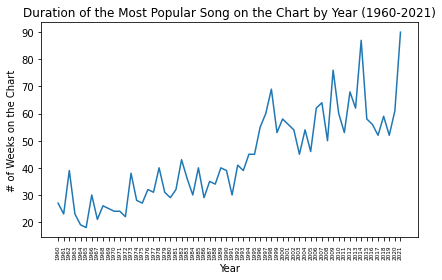

In [17]:
wks_chart_max=pd.DataFrame(wks_chart.groupby('year').wks_chart.max())
plt.plot(wks_chart_max.index, wks_chart_max.wks_chart)
#fig, ax = plt.subplots()
#ax.plot_date(wks_chart_trend.index, wks_chart_trend.wks_chart)
#fig.autofmt_xdate()
plt.xticks(rotation=90, fontsize = 'xx-small')
plt.xlabel('Year')
plt.ylabel('# of Weeks on the Chart')
plt.title('Duration of the Most Popular Song on the Chart by Year (1960-2021)')
plt.tight_layout()

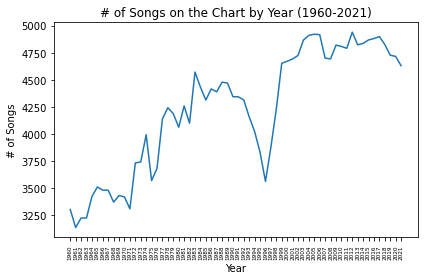

In [18]:
wks_chart_counts=pd.DataFrame(songs.groupby(['year']).count())
plt.plot(wks_chart_counts.index, wks_chart_counts.g_url)
plt.xticks(rotation=90, fontsize = 'xx-small')
plt.xlabel('Year')
plt.ylabel('# of Songs')
plt.title('# of Songs on the Chart by Year (1960-2021)')
plt.tight_layout()

#### B. Song Lyric Visualization

We then decided to visualize the song lyrics in relation to one another using SVD. To do this, we first set up a decades column using the date column from before in order to have a have another variable to group the visualization by. Then, we used a count vectorizer to fit the song lyrics, and plotted all the songs together, then the songs grouped by decade, and then each the songs of decade separately.

In [19]:
# drop duplicates and na values
songs_trun=songs[['lyrics']].drop_duplicates()
songs_trun.dropna(inplace=True)

# add year column to dataframe without duplicates
same_songs = songs.groupby('lyrics')
years = pd.DataFrame(round(same_songs.year.median()))
songs_trun=songs_trun.merge(years, on='lyrics')

In [20]:
print('Number of unique songs scraped:', len(songs_trun))
songs_trun['decade']=songs_trun['year'].astype(str)
songs_trun['decade'] = (songs_trun['decade'].str[0:3].astype(int))*10
songs_trun.head()

Number of unique songs scraped: 21950


,lyrics,year,decade
0,Out in the West Texas town of El PasoI fell in...,1960.0,1960
1,I'll never let you goWhy? Because I love youI'...,1960.0,1960
2,"On the bank of the riverStood Running Bear, yo...",1960.0,1960
3,"Heartaches by the number, troubles by the scor...",1960.0,1960
4,"When somebody leaves you, that's the time to c...",1960.0,1960


In [21]:
# Vectorize for the sake of SVD 

vectorizer = CountVectorizer( #token counts
    input = 'content',
    #preprocessor=pre_proc,
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', 
    lowercase = True,
    min_df = 0.01, #chunk by song
    max_df = 0.9    
)

X = vectorizer.fit_transform(songs_trun['lyrics'])
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized song length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (21950, 1130)
Total vectorized words in the corpus: 4429954
Average vectorized song length: 201 tokens


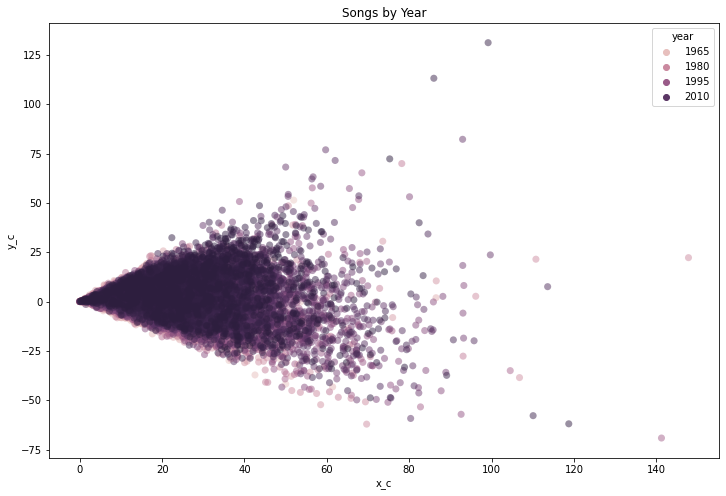

In [22]:
# by year
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['year'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Year')
plt.show()

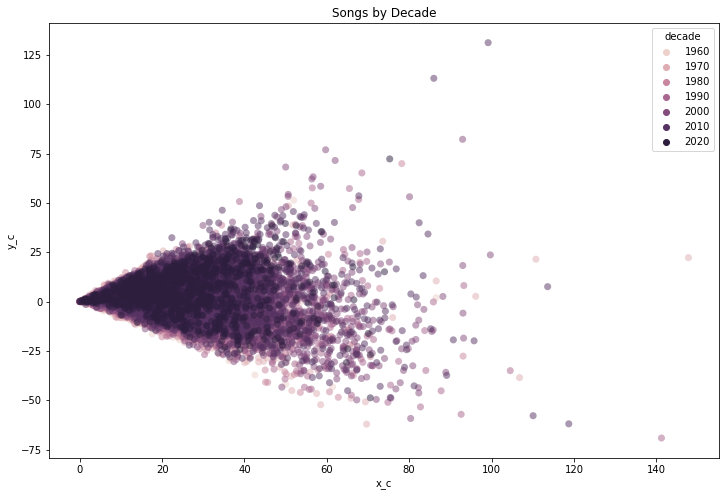

In [23]:
# by decade
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Decade')
plt.show()

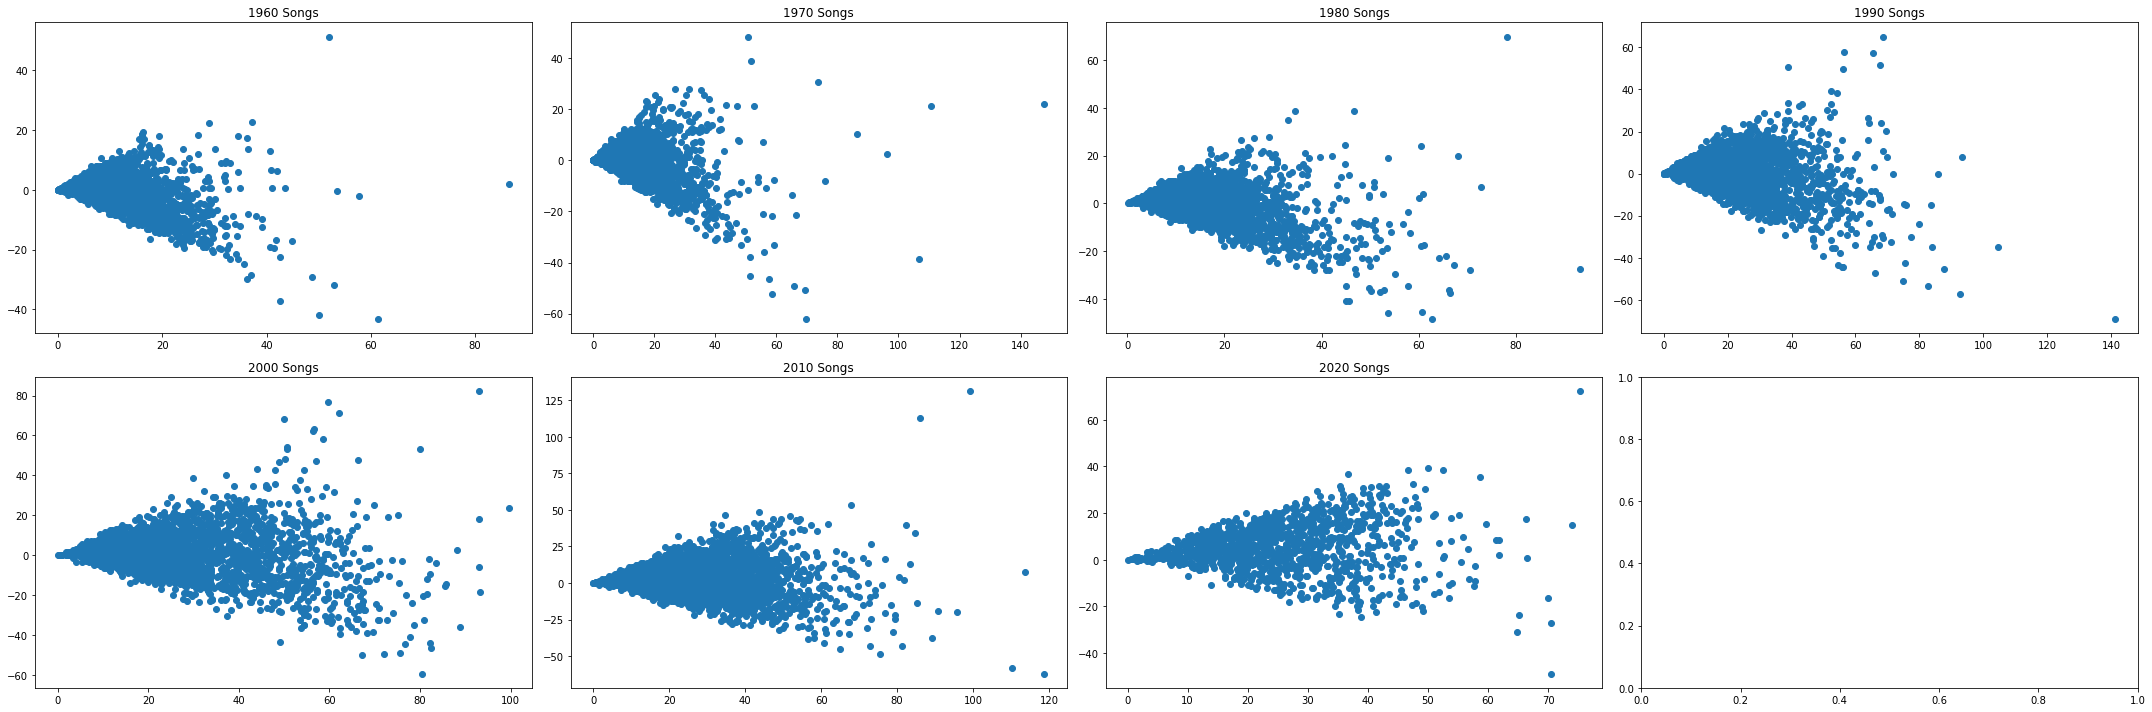

In [24]:
# separate each decade

x=0
fig, axs = plt.subplots(2, 4, figsize=(30,10))
axs = axs.ravel()
for decade in sorted(songs_trun['decade'].unique()):
    axs[x].scatter(songs_trun[songs_trun.decade == decade]['x_c'], songs_trun[songs_trun.decade == decade]['y_c'])
    axs[x].set_title(f'{decade} Songs')
    x+=1
plt.tight_layout()
plt.show()

We can see from these graphs that the general shape of the distribution of songs is relatively constant through the years. For each decade, we can see that the main cluster of songs is about the origin of the graph, with a funnel shape spreading outwards. For some decades, however, the distribution of song lyrics extends much further, suggesting that in those years, the song lyrics of the top 100 songs were less homogeneous than for other years. The graph with the shortest range of x values is the decade of 2020, but this is likely because there is not much data for this decade, considering we are only in the 2 year of the decade, and it is not yet half over. Therefore, if we look at the decade with the second shortest range of x values, we see that it is the 1960s. In looking into the music of 1960s, the cohesiveness of the songs makes sense, as the music scene in the 1960s was largely dominated by rock music, pop rock, psychdelic rock, blues rock, or folk rock. The American rock music of the 60s saw a merging of the rock scene from the decade before into a more international variant, which could help explain the similarities between the song lyrics, as mainstream rock music could have tackled similar contents (https://en.wikipedia.org/wiki/1960s_in_music).

#### C. Which songs are the closest together and which ones are the farthest apart from the rest?
To investigate this further, we decided to look into both the songs that were clustered right at the origin as well as the songs farthest away from the origin. We found the min and max of the y values and the max x value to see which songs there were. The songs that were the farthest outliers in 1960 were 'Ride!' by Dee Dee Sharp, 'By the Time I get To Phoenix' by Isaac Hayes, and 'You' by Marvin Gaye. None of these songs held a number one position on the chart at its peak, althought 'Ride!' was the highest with a peak position of 5. In addition, none of the songs were close to holding the longest time on the chart. In the 60s, the songs that held the record for the longest time on the chart was 'The Twist' by Chubby Checker', at 39 weeks. The longest among the three farthest outliers was again 'Ride!' with 13 weeks on the chart. We also looked at the songs that were clustered right at the origin. We found that these songs were probably clustered around here because they are either very short or repetitive. For example, the Batman Theme is less than one stanza long, and only contains the words "Batman" and "da". Another reason could be the fact that the song is in a different language, and thus the lyrics were not processed correctly because our methods do not allow us to, such as '上を向いて歩こう' (Sukiyaki). However, Sukiyaki held a number one position on the chart, and was on the chart for 14 weeks, a higher position and longer time than any other song in the cluster.

#### The Music of the 60s

In [25]:
songs1960=songs_trun[songs_trun['decade']==1960]
outlier1960=songs1960[songs1960['y_c']==max(songs1960['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==outlier1960[0]]

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
9750,41,1963-01-12,Ride!,Dee Dee Sharp,NaN,5,13,https://www.billboard.com/charts/hot-100/1963-...,https://www.genius.com/Dee-Dee-Sharp-Ride-lyrics,"Let's pony again(Get it, get it, get it, get i...",1963,1960


In [26]:
talloutlier1960=songs1960[songs1960['x_c']==max(songs1960['x_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==talloutlier1960[0]]

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
32864,37,1969-10-18,By The Time I Get To Phoenix,Isaac Hayes,NaN,37,8,https://www.billboard.com/charts/hot-100/1969-...,https://www.genius.com/Isaac-Hayes-By-The-Time...,"Awww, yeahMmmm, hmmm, hmmm, mmmm, mmmm, mmmm, ...",1969,1960


In [27]:
shortoutlier1960=songs1960[songs1960['y_c']==min(songs1960['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==shortoutlier1960[0]]

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
27227,47,1968-02-24,You,Marvin Gaye,NaN,34,7,https://www.billboard.com/charts/hot-100/1968-...,https://www.genius.com/Marvin-Gaye-You-lyrics,"Ooh, you, you I seeIn my mirror in the morning...",1968,1960


In [28]:
median1960 = songs1960[(songs1960['y_c'] > -.1)&(songs1960['y_c'] < .1)&(songs1960['x_c'] < 1)].sort_values(by='y_c')

nn=median1960.merge(wks_chart, on='lyrics')

print('Songs clustered at the origin: \n')
display(nn[['title', 'artist1','peak_pos', 'wks_chart']])
print(nn.g_url.values,'\n')
print('Lyrics to "Mint Julep" by Chet Atkins:')
print(nn[nn['g_url'] == 'https://www.genius.com/Chet-Atkins-One-Mint-Julep-lyrics'].lyrics.values)

print('\nLyrics to "The Batman Theme by The Marketts:')
print(nn[nn['g_url'] == 'https://www.genius.com/The-Marketts-Batman-Theme-lyrics'].lyrics.values)

Songs clustered at the origin: 



,title,artist1,peak_pos,wks_chart
0,Mr. Songwriter,Connie Stevens,43,8
1,One Mint Julep,Chet Atkins,82,6
2,Sukiyaki,Kyu Sakamoto,1,14
3,Jingo,Santana,56,8
4,Beatnik Fly,Johnny And The Hurricanes,15,13
5,Point Panic,The Surfaris,49,8
6,Batman Theme,The Marketts,17,9
7,Milord,Bobby Darin,45,9


['https://www.genius.com/Connie-Stevens-Mr-Songwriter-lyrics'
 'https://www.genius.com/Chet-Atkins-One-Mint-Julep-lyrics'
 'https://www.genius.com/Kyu-Sakamoto-Sukiyaki-lyrics'
 'https://www.genius.com/Santana-Jingo-lyrics'
 'https://www.genius.com/Johnny-And-The-Hurricanes-Beatnik-Fly-lyrics'
 'https://www.genius.com/The-Surfaris-Point-Panic-lyrics'
 'https://www.genius.com/The-Marketts-Batman-Theme-lyrics'
 'https://www.genius.com/Bobby-Darin-Milord-lyrics'] 

Lyrics to "Mint Julep" by Chet Atkins:
['Mint JulepMint JulepMint JulepMint JulepMint JulepMint Julep']

Lyrics to "The Batman Theme by The Marketts:
['Batman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanDa da da da da da da da da da da da da da da da daBatman!']


#### The Music of the 90s

We then decided to do the same thing for the decade that had the largest distribution as well, which was the 1990s. In the 1990s, hip hop grew to be very successful in the industry. Reggae, contemporary R&B, and urban music was also very popular, and many fusion genres were created from these genres, include jack swing, neo-soul, and g-funk. Still, teen pop was extremely popular, continuing from the decade before. Rock music was also very popular, and the music scene saw the emergence of grunge, alternative rock, punk rock, and nu metal. In addition electronic music grew very popular during the 90s, with house, techno, rave, and happy hardcore reaching great success (https://en.wikipedia.org/wiki/1990s_in_music). The farthest outliers from the 1990s include the songs '1st of the Tha Month' by Bone Thugs-N-Harmony, 'Giving You The Benefit' by Pebbles, and 'Kiss You Back' by Digital Underground.

In [29]:
songs1990=songs_trun[songs_trun['decade']==1990]
outlier1990=songs1990[songs1990['y_c']==max(songs1990['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==outlier1990[0]]

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
140116,97,1996-01-06,1st Of Tha Month,Bone Thugs-N-Harmony,NaN,14,20,https://www.billboard.com/charts/hot-100/1996-...,https://www.genius.com/Bone-Thugs-N-Harmony-1s...,"Wake up, wake up, wake up, wake up, wake upIt'...",1996,1990


In [30]:
talloutlier1990=songs1990[songs1990['x_c']>100].lyrics.values
display(wks_chart[wks_chart['lyrics']==talloutlier1990[0]])
display(wks_chart[wks_chart['lyrics']==talloutlier1990[1]])

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
119550,94,1991-01-12,Giving You The Benefit,Pebbles,NaN,4,22,https://www.billboard.com/charts/hot-100/1991-...,https://www.genius.com/Pebbles-Giving-You-The-...,Lately I've been trying to figure out your min...,1991,1990


,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics,year,decade
124758,59,1992-03-28,Kiss You Back,Digital Underground,NaN,40,20,https://www.billboard.com/charts/hot-100/1992-...,https://www.genius.com/Digital-Underground-Kis...,"Alright, let's goShimmy, shimmy cocoa popYeah,...",1992,1990


In [31]:
median1990 = songs1990[(songs1990['y_c'] > -.2)&(songs1990['y_c'] < .2)&(songs1990['x_c'] < 1)].sort_values(by='y_c')

mm=median1990.merge(wks_chart, on='lyrics')

print('Songs clustered at the origin: \n')
display(mm[['title', 'artist1','peak_pos', 'wks_chart']])
print(mm.g_url.values,'\n')
print('Lyrics to "Sadeness Part 1" by Enignma:')
print(mm[mm['g_url'] == 'https://www.genius.com/Enigma-Sadeness-Part-1-lyrics'].lyrics.values)

print('\nLyrics to "God Bless the Child by Shania Twain:')
print(mm[mm['g_url'] == 'https://www.genius.com/Shania-Twain-God-Bless-The-Child-lyrics'].lyrics.values)

Songs clustered at the origin: 



,title,artist1,peak_pos,wks_chart
0,Sadeness Part 1,Enigma,5,18
1,Macarena,Los Del Mar,71,15
2,Sweet Lullaby,Deep Forest,78,8
3,Lambada,Kaoma,46,12
4,Macarena,Los Del Rio,23,21
5,Dur Dur D'etre BeBe! (It's Tough To Be A Baby),Jordy,58,9
6,God Bless The Child,Shania Twain,75,5


['https://www.genius.com/Enigma-Sadeness-Part-1-lyrics'
 'https://www.genius.com/Los-Del-Mar-Macarena-lyrics'
 'https://www.genius.com/Deep-Forest-Sweet-Lullaby-lyrics'
 'https://www.genius.com/Kaoma-Lambada-lyrics'
 'https://www.genius.com/Los-Del-Rio-Macarena-lyrics'
 'https://www.genius.com/Jordy-Dur-Dur-Detre-BeBe-Its-Tough-To-Be-A-Baby-lyrics'
 'https://www.genius.com/Shania-Twain-God-Bless-The-Child-lyrics'] 

Lyrics to "Sadeness Part 1" by Enignma:
['誰もが通り過ぎてく気にも止めない どうしようもないそんなガラクタを 大切そうに抱えていた周りは不思議なカオで少し離れた場所から見てたそれでも笑って言ってくれた「宝物だ」と大きな何かを手に入れながら 失ったものもあったかな今となってはもうわからないよね取り戾したところで きっと微妙に違っているハズで君がいるなら どんな時も 笑ってるよ君がいるなら どんな時も 笑ってるよ泣いているよ 生きているよ君がいなきゃ何もなかった自分自身だったか周りだったかそれともただの時計だったかな壞れそうになってたものはガラクタを守り続ける腕は どんなに痛かったことだろう何を犧牲にしてきたのだろう決してキレイなマルにはなれないけれどね いびつに輝くよ君が見つけた 広くもない こんな道で君が見つけた 広くもない 狹くもないこんな道で どうにかして君がひとり磨きあげた君がいたから どんな時も 笑ってたよ君がいたから どんな時も 笑ってたよ泣いていたよ 生きていたよ君がいなきゃ何もなかった']

Lyrics to "God Bless the Child by Shania Twain:
['Hallelujah, hallelujahGod bless the child who suf

The subset of the songs most closely clustered around the origin for 1990 seem to all be non-English songs, except for 'God Bless the Child' by Shania Twain. Again as before, this song is highly repetitive and short, most likely why it is located so near to the rest of the songs.

#### D. Topic Modeling Lyrical Content

With this background knowledge about the relative homogeneity of the top 100 songs per decade, we started our topic modeling. We began by testing the model with five topics and 10 iterations, and then we tried 5 topic with 15 iterations. However, for both of these models the perplexity score ended up over 250, so we decided to increase the number of topics to try and lower the perplexity score. We then tried a series of models, with varying combinations of topics and interations. We found the best way to get a lower perplexity was to increase the amount of iterations rather than to drastically increase the number of topics because when examining the topics, the more we had, the less meaningful each one became. When evaluating the model at 15 topics, we could not find discernable differences between many of them, so we decided to go with and LDA model that used 10 topics with 20 iterations. 

In [32]:
# code from lec 20-21

In [33]:
lda = LatentDirichletAllocation(
    n_components=5, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 289.3522
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 278.5254
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 275.0199
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 273.1702
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 272.0104


LatentDirichletAllocation(evaluate_every=2, n_components=5, n_jobs=-1,
                          verbose=1)

In [34]:
lda = LatentDirichletAllocation(
    n_components=5, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=15,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15, perplexity: 284.6783
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15, perplexity: 274.9579
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15, perplexity: 272.0244
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15, perplexity: 270.6226
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15, perplexity: 269.9185
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15, perplexity: 269.5222
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15, perplexity: 269.2548
iteration: 15 of max_iter: 15


LatentDirichletAllocation(evaluate_every=2, max_iter=15, n_components=5,
                          n_jobs=-1, verbose=1)

In [48]:
lda = LatentDirichletAllocation(
    n_components=8, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 285.9695
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 273.0365
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 268.5747
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 266.4145
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 265.1312


LatentDirichletAllocation(evaluate_every=2, n_components=8, n_jobs=-1,
                          verbose=1)

In [35]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 278.9661
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 266.8680
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 262.4413
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 260.5359
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 259.5710


LatentDirichletAllocation(evaluate_every=2, n_jobs=-1, verbose=1)

In [36]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=15,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15, perplexity: 281.2814
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15, perplexity: 267.7988
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15, perplexity: 263.6786
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15, perplexity: 261.8909
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15, perplexity: 260.8973
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15, perplexity: 260.2223
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15, perplexity: 259.7352
iteration: 15 of max_iter: 15


LatentDirichletAllocation(evaluate_every=2, max_iter=15, n_jobs=-1, verbose=1)

In [49]:
lda = LatentDirichletAllocation(
    n_components=15, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=20,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 276.0380
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 262.8682
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 258.6221
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 256.5541
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 255.2997
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 254.4736
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 253.8959
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 253.4544
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 253.0912
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 252.8064


LatentDirichletAllocation(evaluate_every=2, max_iter=20, n_components=15,
                          n_jobs=-1, verbose=1)

In [37]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=20,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 282.6372
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 270.5840
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 265.8441
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 263.3672
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 261.8976
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 260.9411
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 260.2552
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 259.7177
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 259.2914
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 258.9110


LatentDirichletAllocation(evaluate_every=2, max_iter=20, n_jobs=-1, verbose=1)

In [38]:
# source: lecture 20-21 topic models

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

The topics that we ended up with are shown below. Some of the major characteristics of the topics are clear from the top 15 words of the topics. For example, topic 0 has many words relating to woman (she, her, girl) and topic 4 has words relating to men (he, man, his). Futher, topic 6 is likely constructed from words that are related to relationships, given the words 'love', 'you' 'me', need', 'heart', and 'take'. and topic 8 is likely constructed from ad-libs or filler type words like 'la', 'na', 'woah', and 'yeah'. Looking at the pyLDAvis output, we can see that the topic constructed with ad-libs is the farthest apart from the rest of the topics. It makes sense that this topic is the farthest away from the others inter-topic wise because the these words are most likely the least related to the others considering they are not actually words.

In [39]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=20, hide_stops=False)

Topic  0: my she in her and was of on got that for with me said out girl all had at up
Topic  1: you love me my your can it that so in and is for feel know need heart re never make
Topic  2: it we get let and go can up on got gonna da make all right our re stop gotta do
Topic  3: it you that like up my me on in and ain with yeah got they get don know your all
Topic  4: oh you yeah do baby me ooh wanna what it want re my girl like know ah don your just
Topic  5: on he down back his him man and take it come me in keep boy you is for up that
Topic  6: you be me don ll your my know ve can if for on been wanna that with want and got
Topic  7: and in on your na of all night is re dance rock it up with like you gonna new out
Topic  8: la no hey me ya ha de say don yo ready hoo mi ah body your why mama you woo
Topic  9: you of that and in is it all re just are for what one not this we was your never



In [40]:
pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (21950, 10)


Our doc-topic matrix is (21950, 10), representing the distribution of each of the 10 topics across the 21950 songs. Using this matrix, we first did some exploratory data analysis. We made a correlation plot, which showed that the none of the topics have a positive correlation, but most do have a slightly negative correlation. The one with the highest negative correlation was topic 6 and 7 (5 and 6 in the list above). This was interesting because inter-topic wise, they overlap quite a bit, but topic 6 (5) contains more words that can be negatively associated, such as 'never', 'give', 'away'. This could make sense because the songs in the different topics could both be talking about relationships, but with a different tone, reflected in the featured words.

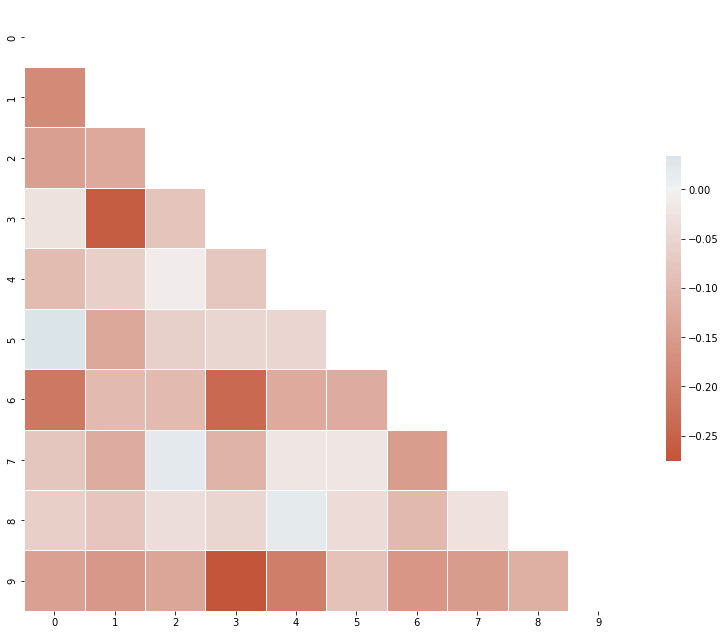

In [42]:
# source lec 20-21
corr = np.corrcoef(doc_topic_matrix.T)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

We also decided to plot the songs by time to see if the topics were more popular in songs of certain years. Many of the songs have a temporal trend. For example, the graph of the distribution of topics per year for topic 7 sees a sharp rise in the 1990s, with another, sharper rise in the mid 2010s. Looking into the words for this topic, it sharp increase of the topic does make sense. The topic, unlike the others, contains a mixture of swear words and slurs. Accorinding to a study on the use of profanity on the American Billboard Charts, te use of this profanity in songs is most widespread in the pop and rap/hip hop genre, with artists like A$AP Rocky, Drake, Kendrick Lamar, and Nicki Minaj having the songs with the most profanity. In addition, 

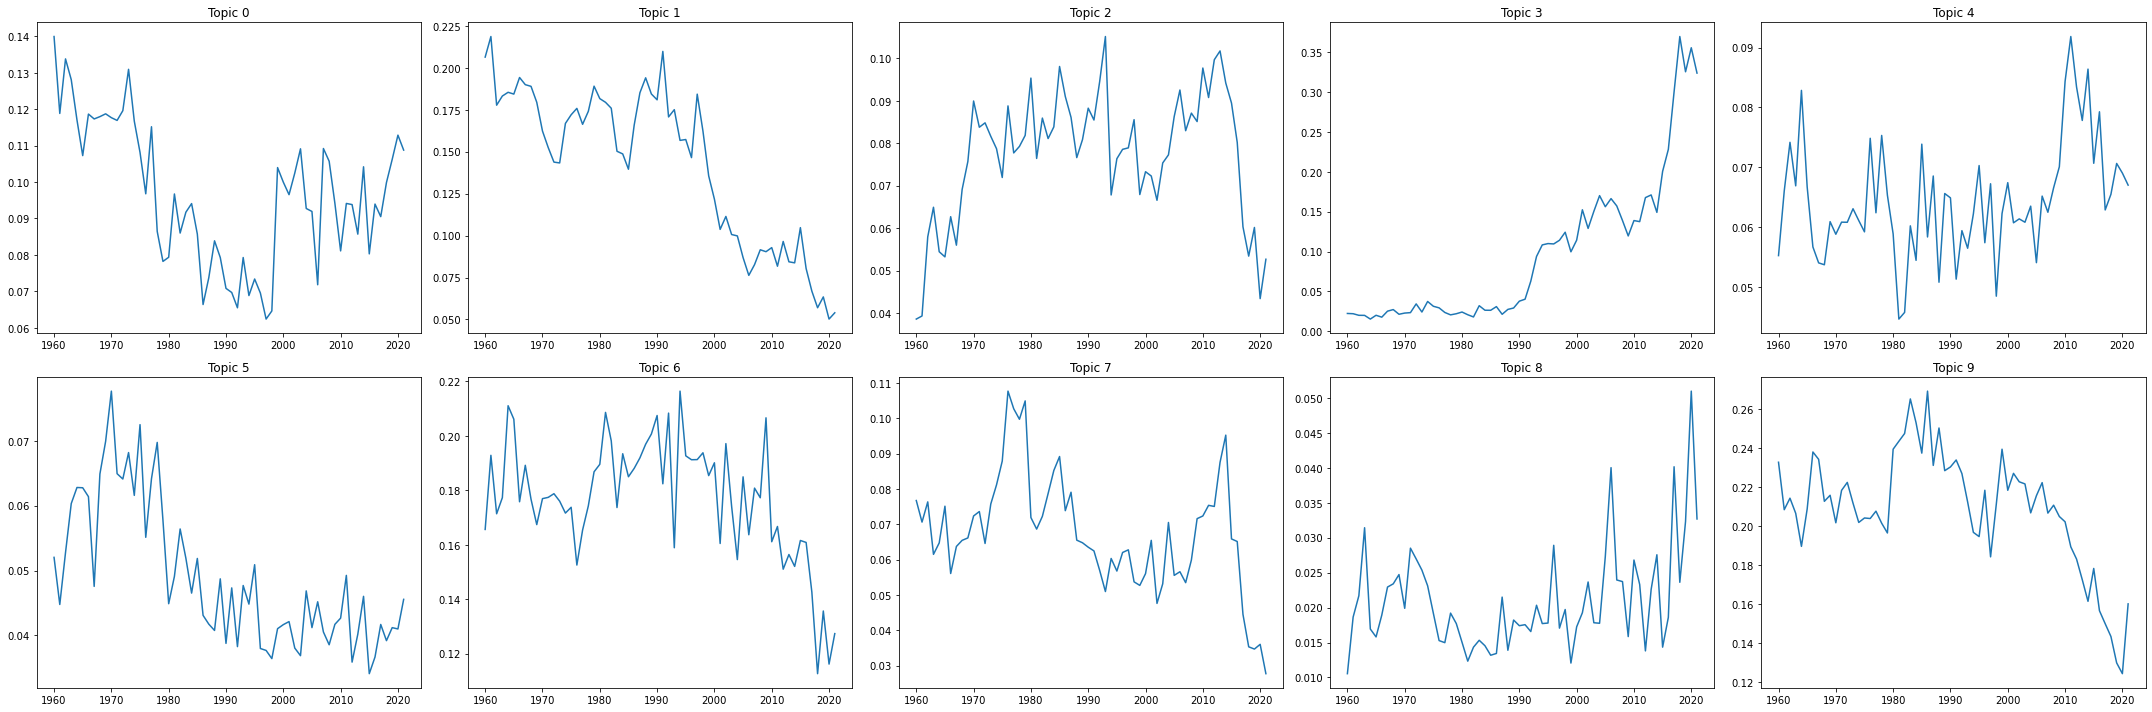

In [43]:
# Time series
n_cols = 5
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(30,10))
axs = axs.ravel()

valid_years = sorted(np.unique(songs_trun.year))


for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for year in valid_years:
        mask = np.equal(songs_trun['year'], year)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_years, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

Now, using these topcs, we can try to predict the time in which 

## 3. Results

## 4. Discussion and Conclusions

## 5. Resources Consulted

##### 1. Dataset Creation
Removing text in parentheses in a string (modified for brackets): https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex <br>
Python regex (re) library documentation: https://www.pythontutorial.net/python-regex/python-regex-sub/ <br>
Pandas datetime objects documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html <br>

##### 2. Methods and Results
LDA Topic Modeling: INFO 3350 Lecture 20-21
GridSearchCV with logistic regression: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5 <br>
LogisticRegression parameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
Formatting arrays: https://stackoverflow.com/questions/30813044/sklearn-found-arrays-with-inconsistent-numbers-of-samples-when-calling-linearre

##### 3. Other
History of music: https://en.wikipedia.org/wiki/1960s_in_music, https://en.wikipedia.org/wiki/1990s_in_music

### Bag of Words (Word Counts)

In [45]:
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=0.1,
    max_df=0.9,
    norm='l2',
    use_idf=True,)

In [46]:
X = vectorizer.fit_transform(songs['lyrics'])
X_train = StandardScaler().fit_transform(X.todense())
print("Matrix shape:", X_train.shape)
print("Mean scaled value:", np.mean(X_train))

C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Matrix shape: (262021, 159)
Mean scaled value: -2.2059674688123217e-15


In [48]:
y_year=songs.year.values
y_decade=songs.decade.values

In [53]:
print('10-fold cv score:', np.mean(cross_val_score(LinearRegression(), X_train, y_year, scoring='r2', cv=10)))

10-fold cv score: -87.67238981552244


In [50]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_year, cv=10)))

10-fold cv score: 0.10367502891609146


In [51]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_decade, cv=10)))

10-fold cv score: 0.3231154051967059


In [70]:
matrix_n= []
feat_n = [50,100,120,150]
for x in feat_n:
    print(x)
    vect = TfidfVectorizer(
        encoding='utf-8',
        min_df=0.1,
        max_df=0.9,
        norm='l2',
        use_idf=True,
        max_features=x)
    matrix = vect.fit_transform(songs['lyrics'])
    X_train_Z = StandardScaler().fit_transform(matrix.todense())
   # dict_key=str(x)
    matrix_n.append(X_train_Z)

50


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


100


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


120


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


150


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [73]:
for x in range(len(matrix_n)):
    print("Number of features:",feat_n[x])
    print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), matrix_n[x], y_decade, cv=10)))

Number of features: 50
10-fold cv score: 0.29136599820237674
Number of features: 100
10-fold cv score: 0.3146809731432207
Number of features: 120
10-fold cv score: 0.31640984778200787
Number of features: 150
10-fold cv score: 0.3205698074584874
